In [1]:
import os
import pandas as pd
import numpy as np
import bisect
import pickle
import math
from PIL import Image
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# For ResNet
try:
  import timm
except:
  print('timm does not exist')
  !pip install timm
  import timm

try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

c:\Users\shavo.LAPTOP-HEST3BVP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Preprocessing & Feature Engineering
- Resize images to 64x64
- Convert to grayscale
- Normalize to range [0, 1]
- Generate HOG features

Note:
- HOG features:
    - TLDR: These features describes the image in terms of its edges direction and magnitude in a localised area of 8 x 8 pixels (see image below)
    - More detailed explanation here: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
- Labels: {0: tops, 1: bottoms, 2: bags, 3: shoes, 4: others}
- Creates: 
    - X_train, X_test
    - X_train_hog, X_test_hog
    - y_train, y_test

In [2]:
data_paths = [os.path.join("dataset","train"), os.path.join("dataset","test")]
categories = ["tops", "bottoms", "bags", "shoes", "others"]
r1, r2 = 64, 64

X_data_train = []
X_data_train_hog = []
y_data_train = []

X_data_test = []
X_data_test_hog = []
y_data_test = []

for data_path in data_paths:
    for i, category in enumerate(categories):
        cat_path = os.path.join(data_path, category)
        for filename in os.listdir(cat_path):
            img_path = os.path.join(cat_path, filename)

            try:
                img = Image.open(img_path)
            except Exception as e:
                print(f"Error processing image '{img_path}': {e}")
                continue

            # Resize images
            img = img.resize((r1, r2)) 

            # Convert to black and white
            img = img.convert("L")

            # Normalize pixel values (0 to 1)
            img = np.array(img) / 255.0

            ###############################
            #   Generating HOG features   #
            ###############################
            fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), visualize=False)

            if "train" in data_path:
                # Flatten image and add to X_data
                X_data_train.append(img.flatten())
                # Add corresponding label to y_data
                y_data_train.append(i)

                X_data_train_hog.append(fd)

            elif "test" in data_path:
                X_data_test.append(img.flatten())
                y_data_test.append(i)

                X_data_test_hog.append(fd)

# Convert lists to np arrays
X_train = np.array(X_data_train)
X_train_hog = np.array(X_data_train_hog)
y_train = np.array(y_data_train)
y_train_hog = np.array(y_data_train)

X_test = np.array(X_data_test)
X_test_hog = np.array(X_data_test_hog)
y_test = np.array(y_data_test)
y_test_hog = np.array(y_data_test)

### Optional: Saving the Dataframes

In [3]:
train_df = pd.DataFrame(data=X_train, columns=[f"pixel_{i}" for i in range(X_train.shape[1])])
train_df['label'] = y_train

test_df = pd.DataFrame(data=X_test, columns=[f"pixel_{i}" for i in range(X_test.shape[1])])
test_df['label'] = y_test

with open("preprocessed_data/train_df.pkl", "wb") as f:
    pickle.dump(train_df, f)

with open("preprocessed_data/test_df.pkl", "wb") as f:
    pickle.dump(test_df, f)

train_df_hog = pd.DataFrame(data=X_train_hog, columns=[f"hog_{i}" for i in range(X_train_hog.shape[1])])
train_df_hog['label'] = y_train_hog

test_df_hog = pd.DataFrame(data=X_test_hog, columns=[f"hog_{i}" for i in range(X_test_hog.shape[1])])
test_df_hog['label'] = y_test_hog

with open("preprocessed_data/hog_train_df.pkl", "wb") as f:
    pickle.dump(train_df_hog, f)

with open("preprocessed_data/hog_test_df.pkl", "wb") as f:
    pickle.dump(test_df_hog, f)

# Model 1: ResNet

In [4]:
class customDataset(Dataset):
    def __init__(self, X, y, r, transform=None):
        self.X = X.reshape((-1,r,r,1))
        self.y = y.reshape(-1,1)
        self.transform = transform
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]

        if self.transform:
            X = self.transform(X)
        
        return X, y
    
    def __len__(self):
        return len(self.X)

In [5]:
# Split training data into train and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.2)

# Define dataset objects
transform = transforms.Compose([transforms.ToTensor()])

r = int(math.sqrt(X_tr.shape[-1]))
ds_train = customDataset(X_tr, y_tr, r, transform=transform)
ds_val = customDataset(X_val, y_val, r, transform=transform)
ds_test = customDataset(X_test, y_test, r, transform=transform)

# Create Dataset Loaders
batch_size = 32
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

In [6]:
timm_model = timm.create_model(model_name="resnet50", pretrained=True, num_classes=5, in_chans=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(timm_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [7]:
def train_step(model, dataloader, optimizer, loss_fn, accuracy_fn, device):
    
    train_loss, train_acc = 0, 0
    all_preds, all_targets, all_probs = [], [], []

    model.to(device)
    model.train()

    for i, (X, y) in enumerate(dataloader):

        # Push to device
        X, y = X.to(device), y.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Feedforward
        logits = model(X.float())
        # Compute loss
        loss = loss_fn(logits, y.long().squeeze())
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()

        train_loss += loss.item()
        y_preds = logits.argmax(dim=1)
        train_acc += accuracy_fn(y_preds, y.long().squeeze()).item()
        probs = F.softmax(logits, dim=1)

        all_preds += [y_preds]
        all_targets += [y.long().squeeze()]
        all_probs += [probs]

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {100* train_acc:.2f}%")
    return train_loss, train_acc, all_preds, all_targets, all_probs

def test_step(model, dataloader, loss_fn, accuracy_fn, device):

    test_loss, test_acc = 0, 0
    all_preds, all_targets, all_probs = [], [], []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X.float())
            loss = loss_fn(logits, y.long().squeeze())

            test_loss += loss.item()
            y_preds = logits.argmax(dim=1)
            test_acc += accuracy_fn(y_preds, y.long().squeeze()).item()
            probs = F.softmax(logits, dim=1)

            all_preds += [y_preds]
            all_targets += [y.long().squeeze()]
            all_probs += [probs]

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {100* test_acc:.2f}%")

    return test_loss, test_acc, all_preds, all_targets, all_probs

In [8]:
epochs = 20
best_val_loss = float("inf")
early_stopping_counter = 0
early_stopping_threshold = 5

for epoch in range(epochs):
    print("-"*50 + f" Current epoch: {epoch + 1} " + "-"*50)
    train_loss, train_acc, train_preds, train_targets, train_probs = train_step(
        model=timm_model,
        dataloader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    val_loss, val_acc, val_preds, val_targets, val_probs = test_step(
        model=timm_model,
        dataloader=val_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(timm_model.state_dict(), "models/resnet_best_model.pth")  # Save the best model
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_threshold:
            print("Early Stopping Triggered")
            break

-------------------------------------------------- Current epoch: 1 --------------------------------------------------
Train loss: 0.37540 | Train accuracy: 86.80%
Test loss: 0.10733 | Test accuracy: 96.66%
-------------------------------------------------- Current epoch: 2 --------------------------------------------------
Train loss: 0.07258 | Train accuracy: 97.52%
Test loss: 0.04573 | Test accuracy: 98.51%
-------------------------------------------------- Current epoch: 3 --------------------------------------------------
Train loss: 0.04370 | Train accuracy: 98.56%
Test loss: 0.06157 | Test accuracy: 97.86%
-------------------------------------------------- Current epoch: 4 --------------------------------------------------
Train loss: 0.03453 | Train accuracy: 98.94%
Test loss: 0.05813 | Test accuracy: 98.18%
-------------------------------------------------- Current epoch: 5 --------------------------------------------------
Train loss: 0.02537 | Train accuracy: 99.24%
Test los

# ResNet Evaluation
Test Results using Best ResNet Model

In [9]:
model_path = "models/resnet_best_model.pth"
timm_model = timm.create_model(model_name="resnet50", num_classes=5, in_chans=1)
timm_model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(timm_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

test_loss, test_acc, test_preds, test_targets, test_probs = test_step(
        model=timm_model,
        dataloader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

Test loss: 0.14422 | Test accuracy: 96.28%


Results for Resnet (without HOG) on test set:
Accuracy: 0.963265306122449
Precision: 0.9560128610895401
Recall: 0.950952380952381
F1 Score: 0.9527273852604786


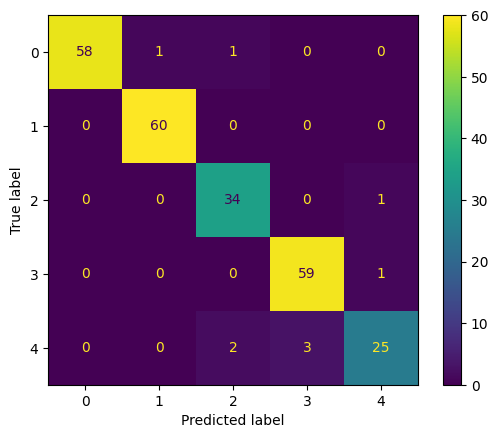

In [10]:
test_preds_list = [pred.item() for batch_preds in test_preds for pred in batch_preds]
test_targets_list = [target.item() for batch_targets in test_targets for target in batch_targets]
test_probs_list = []
for batch_probs in test_probs:
    for prob in batch_probs:
        test_probs_list.append(prob.tolist())

# 1. Accuracy, Precision, Recall, F1 score
accuracy_resnet = accuracy_score(test_targets_list, test_preds_list)
precision_resnet = precision_score(test_targets_list, test_preds_list, average='macro')
recall_resnet = recall_score(test_targets_list, test_preds_list, average='macro')
f1_resnet = f1_score(test_targets_list, test_preds_list, average='macro')

print("Results for Resnet (without HOG) on test set:")
print(f"Accuracy: {accuracy_resnet}")
print(f"Precision: {precision_resnet}")
print(f"Recall: {recall_resnet}")
print(f"F1 Score: {f1_resnet}")

# 2. Confusion Matrix
resnet_cm = confusion_matrix(test_targets_list, test_preds_list)
ConfusionMatrixDisplay(confusion_matrix=resnet_cm).plot()

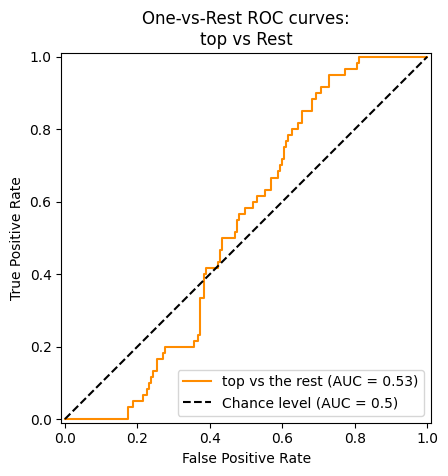

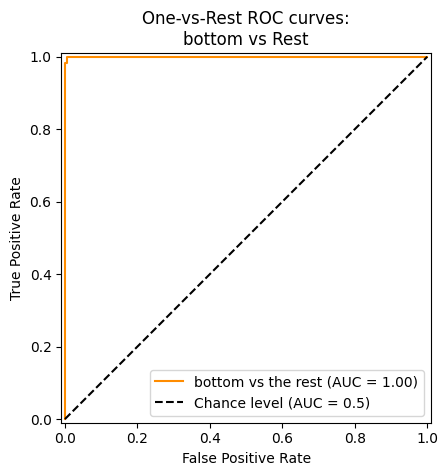

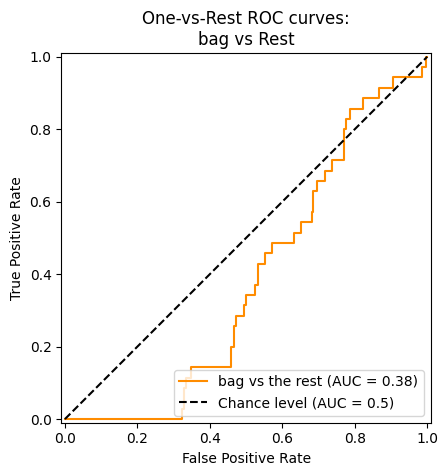

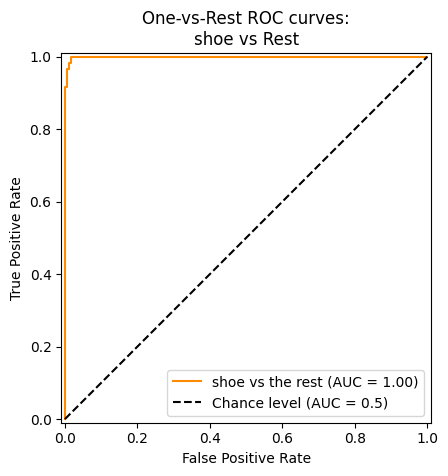

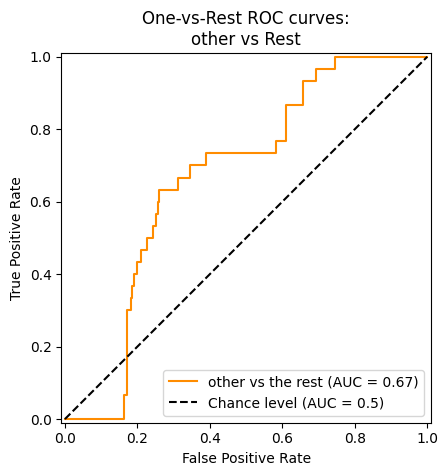

In [11]:
# 3. One vs Rest ROC curve

categories = ["top", "bottom", "bag", "shoe", "other"]
train_targets_list = [target.item() for batch_targets in train_targets for target in batch_targets]
y_train_str = [categories[label] for label in train_targets_list]
y_test_str = [categories[label] for label in test_targets_list]
y_score_arr = np.array(test_probs_list)

label_binarizer = LabelBinarizer().fit(y_train_str)
y_onehot_test = label_binarizer.transform(y_test_str)
y_onehot_test.shape  # (n_samples, n_classes)

for cat in categories:
    class_id = np.flatnonzero(label_binarizer.classes_ == cat)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score_arr[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",
    plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest",
    )

# Model 2: Random Forest

In [60]:
# Creating splits
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

## Random Forest (without HOG Features)

In [82]:
# Testing on validation set
rfc = RandomForestClassifier(random_state = 42) 

rfc.fit(X_tr, y_tr)

# Predict
y_val_pred = rfc.predict(X_val)

# Print results
print("Accuracy for random forest model (without HOG) on validation set:"+str(accuracy_score(y_val, y_val_pred)))

Accuracy for random forest model (without HOG) on validation set:0.7524752475247525


Results for Random Forest (without HOG) on test set:
Accuracy: 0.7061224489795919
Precision: 0.6785741704913333
Recall: 0.6761904761904761
F1 Score: 0.6757288849451604


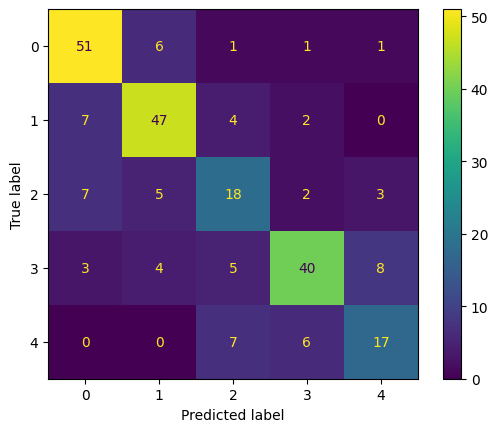

In [83]:
# Testing on test set
y_pred = rfc.predict(X_test)

# Print results
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Results for Random Forest (without HOG) on test set:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

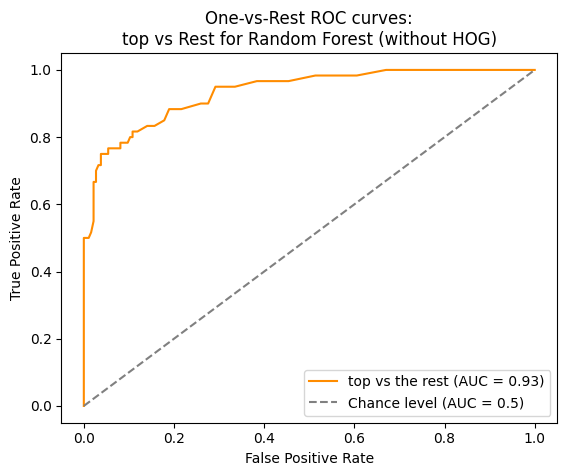

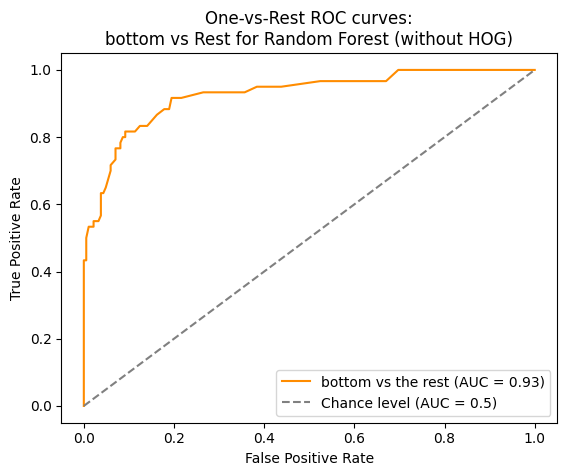

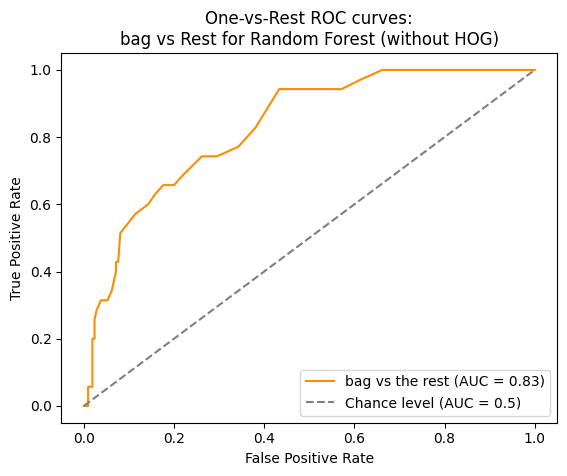

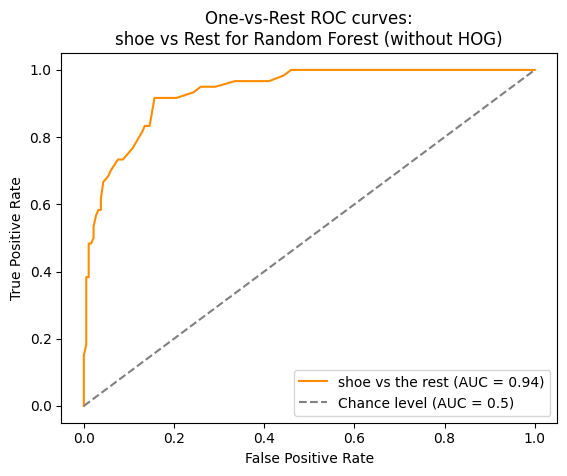

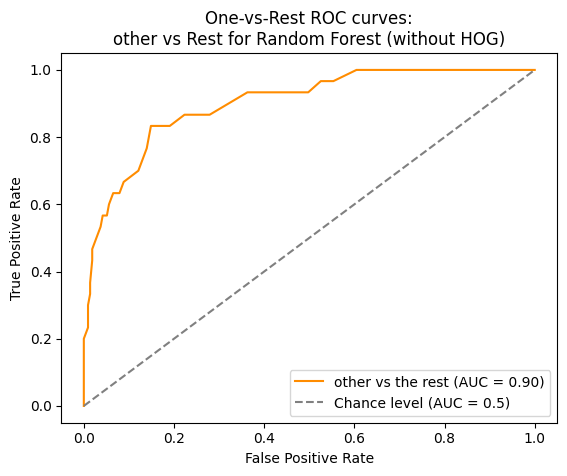

In [81]:
# Plot AUC curves for each category
y_score = rfc.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_tr)
y_onehot_test = label_binarizer.transform(y_test)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for Random Forest (without HOG)",
    )


## Random Forest (with HOG Features)

In [63]:
X_tr_hog, X_val_hog, y_tr_hog, y_val_hog = train_test_split(X_train_hog, y_train_hog, random_state=42, test_size=0.2)

In [79]:
# Testing on validation set
rfc_hog = RandomForestClassifier(random_state = 42) 

rfc_hog.fit(X_tr_hog, y_tr_hog)

# Predict
y_val_pred_hog = rfc_hog.predict(X_val_hog)

# Print results
print("Accuracy for random forest model (with HOG) on validation set: "+str(accuracy_score(y_val_hog, y_val_pred_hog)))

Accuracy for random forest model (with HOG) on validation set: 0.8533186651998533


Results for Random Forest (with HOG) on test set:
Accuracy: 0.7959183673469388
Precision: 0.7727668845315904
Recall: 0.7666666666666666
F1 Score: 0.7629407654393937


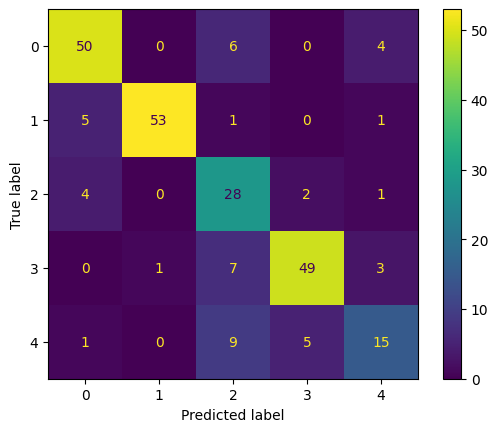

In [80]:
# Testing on test set
y_pred_hog = rfc_hog.predict(X_test_hog)

# Print results
accuracy_rf = accuracy_score(y_test_hog, y_pred_hog)
precision_rf = precision_score(y_test_hog, y_pred_hog, average='macro')
recall_rf = recall_score(y_test_hog, y_pred_hog, average='macro')
f1_rf = f1_score(y_test_hog, y_pred_hog, average='macro')
conf_matrix_rf = confusion_matrix(y_test_hog, y_pred_hog)

print("Results for Random Forest (with HOG) on test set:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf).plot()

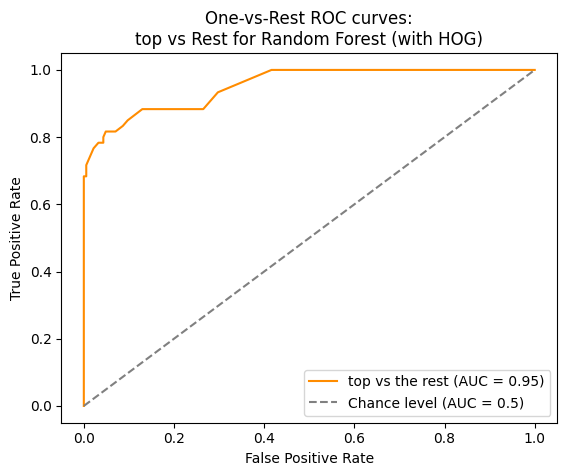

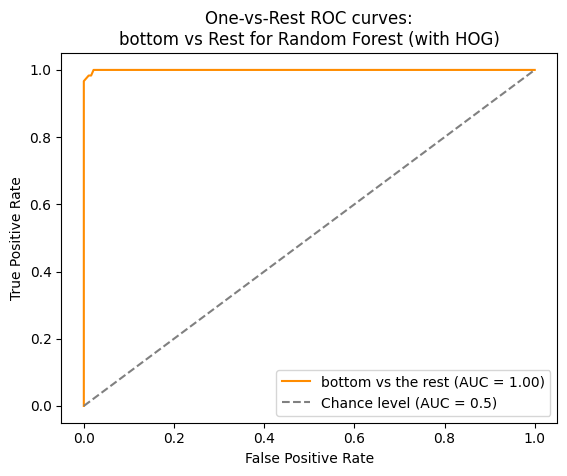

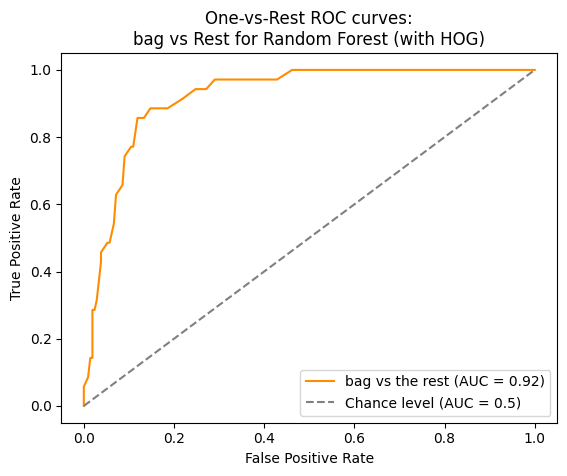

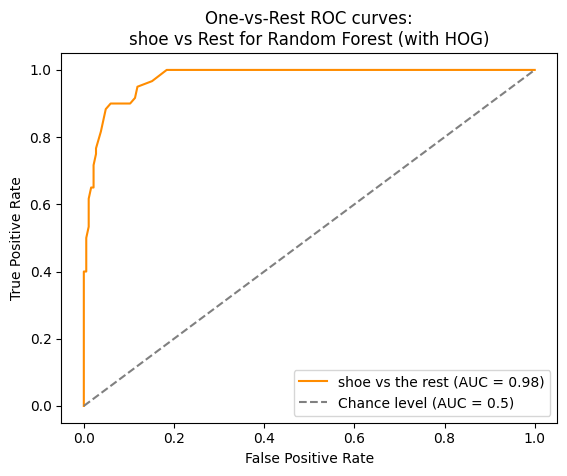

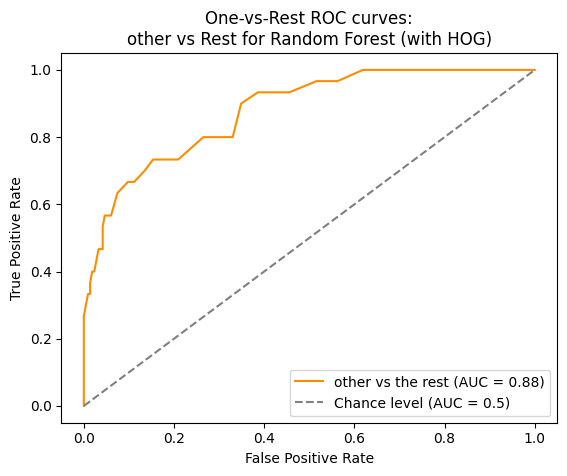

In [78]:
# Plot AUC curves for each category
y_score = rfc_hog.predict_proba(X_test_hog)
label_binarizer = LabelBinarizer().fit(y_tr_hog)
y_onehot_test = label_binarizer.transform(y_test_hog)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for Random Forest (with HOG)",
    )

### Tuning Hyperparameters

In [14]:
# Print default parameters
print("Current params: ", rfc_hog.get_params())

Current params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [15]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
random_grid = {'n_estimators': n_estimators}

model = RandomForestClassifier(random_state = 42)

# Use random search to find the best hyperparameters
rf_pca_rand_search = RandomizedSearchCV(
    estimator = model,
    param_distributions = random_grid,
    n_iter = 5,
    cv = 5,
    random_state = 42
)

rf_pca_rand_search.fit(X_tr_hog, y_tr_hog) # takes 25min to run 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200]},
                   random_state=42)

In [17]:
# Shows the most optimal hyperparameter value
rf_pca_rand_search.best_params_

{'n_estimators': 160}

In [18]:
# Use the most optimal parameters for the model 
rf_tuned = rf_pca_rand_search.best_estimator_
rf_tuned.fit(X_tr_hog, y_tr_hog)

RandomForestClassifier(n_estimators=160, random_state=42)

In [19]:
# Testing tuned model on validation set
y_val_pred_hog = rf_tuned.predict(X_val_hog)

# Print results
print("Accuracy for tuned random forest model on validation set: "+str(accuracy_score(y_val_hog, y_val_pred_hog)))

Accuracy for tuned random forest model on validation set: 0.8599193252658599


Results for tuned random forest model on test set:
Accuracy: 0.8040816326530612
Precision: 0.7768394298291583
Recall: 0.770952380952381
F1 Score: 0.768750668157649


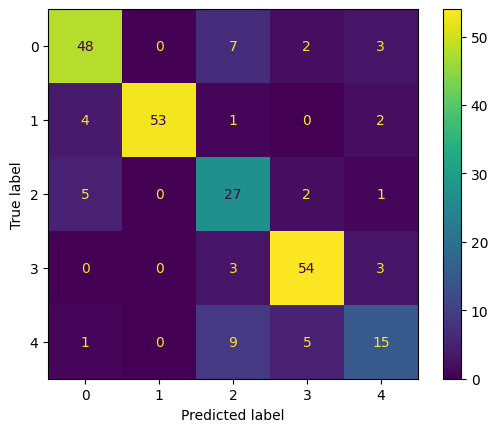

In [66]:
# Testing tuned model on test set
y_pred_hog = rf_tuned.predict(X_test_hog)

# Print results
accuracy_tuned_rf = accuracy_score(y_test_hog, y_pred_hog)
precision_tuned_rf = precision_score(y_test_hog, y_pred_hog, average='macro')
recall_tuned_rf = recall_score(y_test_hog, y_pred_hog, average='macro')
f1_tuned_rf = f1_score(y_test_hog, y_pred_hog, average='macro')
conf_matrix_tuned_rf = confusion_matrix(y_test_hog, y_pred_hog)

print("Results for tuned random forest model on test set:")
print(f"Accuracy: {accuracy_tuned_rf}")
print(f"Precision: {precision_tuned_rf}")
print(f"Recall: {recall_tuned_rf}")
print(f"F1 Score: {f1_tuned_rf}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned_rf).plot()

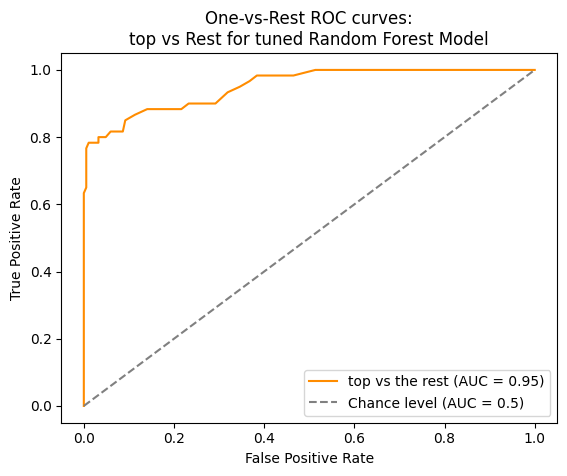

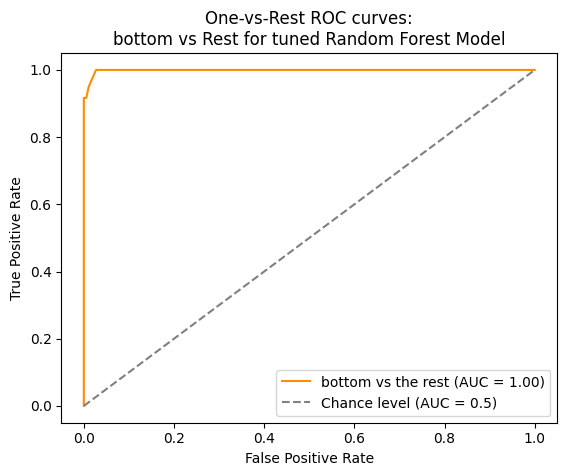

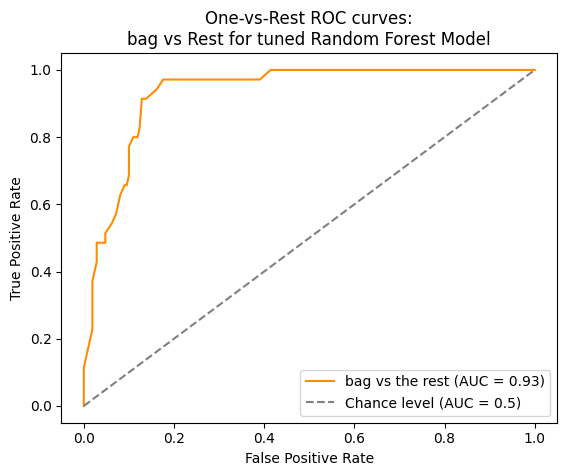

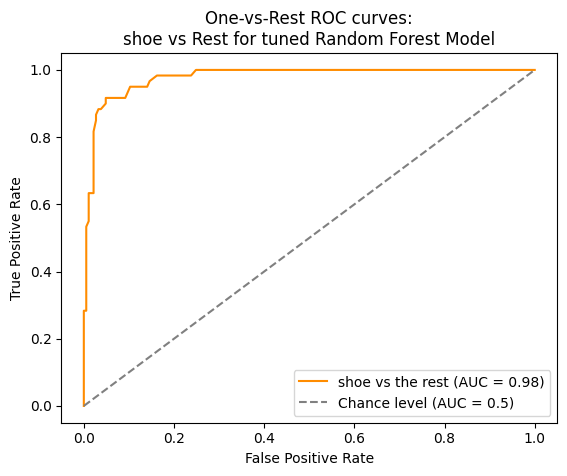

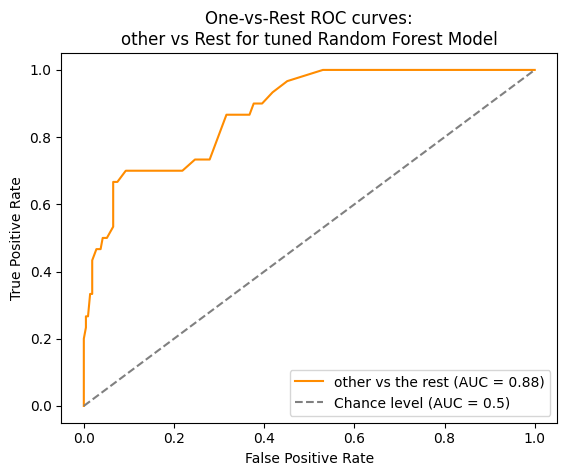

In [67]:
# Plot AUC curves for each category for tuned model
y_score = rf_tuned.predict_proba(X_test_hog)
label_binarizer = LabelBinarizer().fit(y_tr_hog)
y_onehot_test = label_binarizer.transform(y_test_hog)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for tuned Random Forest Model",
    )

In [68]:
# Metrics comparison before and after tuning 
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Random Forest (without HOG)': [accuracy, precision, 
                            recall, f1],
    'Random Forest (with HOG)': [accuracy_rf, precision_rf, 
                            recall_rf, f1_rf],
    'Random Forest after tuning (with HOG)': [accuracy_tuned_rf, precision_tuned_rf, 
                      recall_tuned_rf, f1_tuned_rf]
})

metrics

,Metric,Random Forest (without HOG),Random Forest (with HOG),Random Forest after tuning (with HOG)
0,Accuracy,0.706122,0.795918,0.804082
1,Precision,0.678574,0.772767,0.776839
2,Recall,0.676190,0.766667,0.770952
3,F1 Score,0.675729,0.762941,0.768751


# KNN

## KNN (without HOG Features)

In [69]:
# Creating splits
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

In [77]:
# Testing on validation set
knn = KNeighborsClassifier()

knn.fit(X_tr, y_tr)

# Predict
y_val_pred_knn = knn.predict(X_val)

# Print results
print("Accuracy for KNN model (without HOG) on validation set:"+str(accuracy_score(y_val, y_val_pred_knn)))

Accuracy for KNN model (without HOG) on validation set:0.6607994132746609


Results for KNN (without HOG) on test set:
Accuracy: 0.673469387755102
Precision: 0.6535496662606393
Recall: 0.6195238095238095
F1 Score: 0.6219042308316293


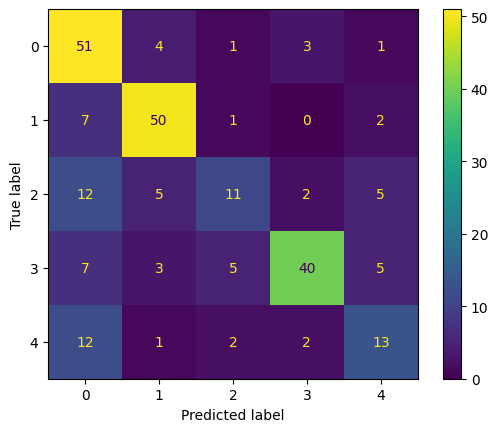

In [70]:
# Testing on test set
y_pred_knn = knn.predict(X_test)

# Print results
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='macro')
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

print("Results for KNN (without HOG) on test set:")
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn).plot()

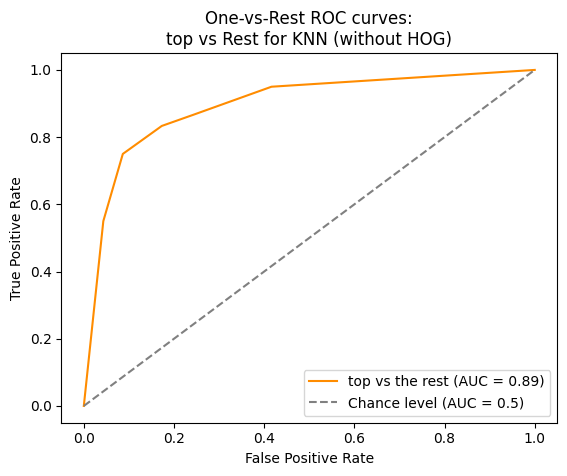

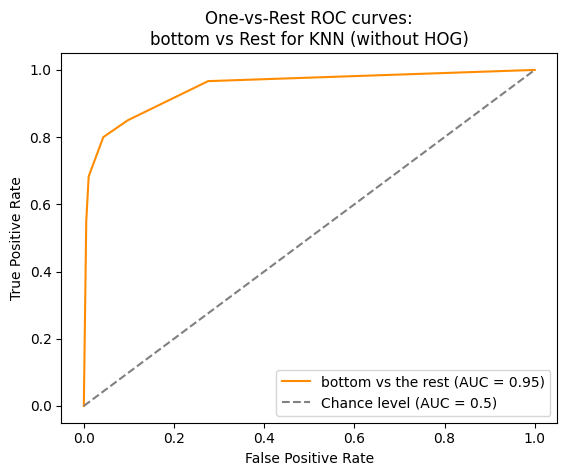

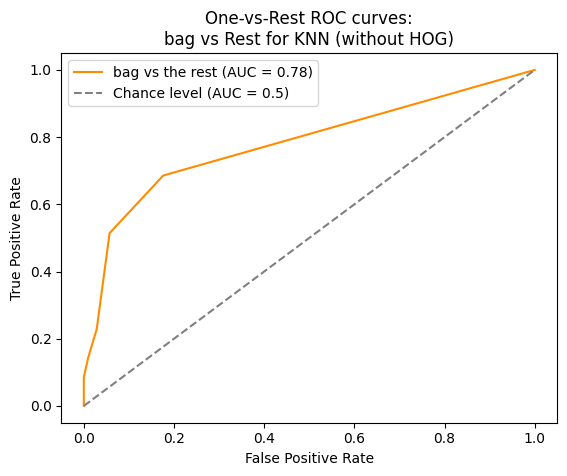

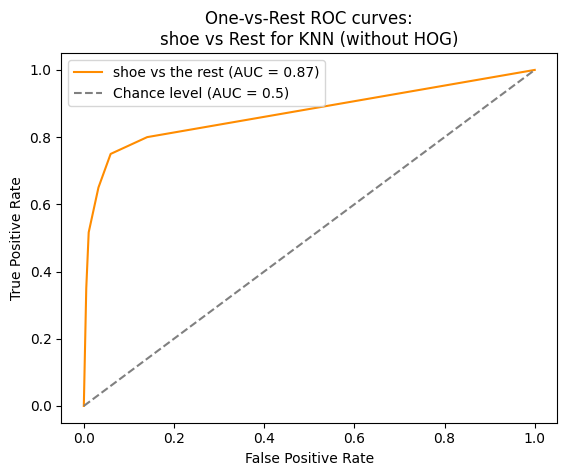

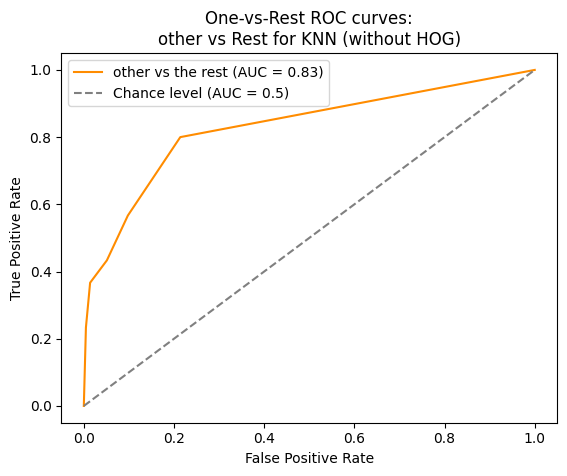

In [71]:
# Plot AUC curves for each category
y_score = knn.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_tr)
y_onehot_test = label_binarizer.transform(y_test)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for KNN (without HOG)",
    )

## KNN (with HOG Features)

In [45]:
X_tr_hog, X_val_hog, y_tr_hog, y_val_hog = train_test_split(X_train_hog, y_train_hog, random_state=42, test_size=0.2)

In [76]:
# Testing on validation set
knn_hog = KNeighborsClassifier()

knn_hog.fit(X_tr_hog, y_tr_hog)

# Predict
y_val_pred_hog_knn = knn_hog.predict(X_val_hog)

# Print results
print("Accuracy for KNN model (with HOG) on validation set: "+str(accuracy_score(y_val_hog, y_val_pred_hog_knn)))

Accuracy for KNN model (with HOG) on validation set: 0.8804547121378804


Results for KNN (with HOG) on test set:
Accuracy: 0.8857142857142857
Precision: 0.8792239220000937
Recall: 0.8733333333333334
F1 Score: 0.8747263529788617


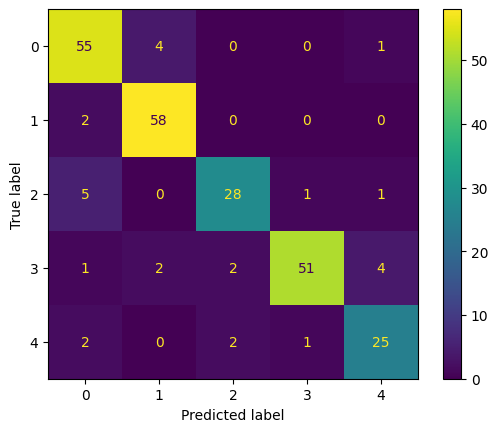

In [72]:
# Testing on test set
y_pred_hog_knn = knn_hog.predict(X_test_hog)

# Print results
accuracy_knn_hog = accuracy_score(y_test_hog, y_pred_hog_knn)
precision_knn_hog = precision_score(y_test_hog, y_pred_hog_knn, average='macro')
recall_knn_hog = recall_score(y_test_hog, y_pred_hog_knn, average='macro')
f1_knn_hog = f1_score(y_test_hog, y_pred_hog_knn, average='macro')
conf_matrix_knn_hog = confusion_matrix(y_test_hog, y_pred_hog_knn)

print("Results for KNN (with HOG) on test set:")
print(f"Accuracy: {accuracy_knn_hog}")
print(f"Precision: {precision_knn_hog}")
print(f"Recall: {recall_knn_hog}")
print(f"F1 Score: {f1_knn_hog}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn_hog).plot()

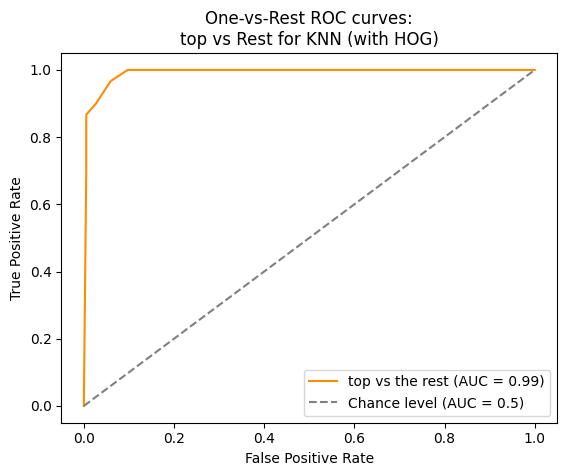

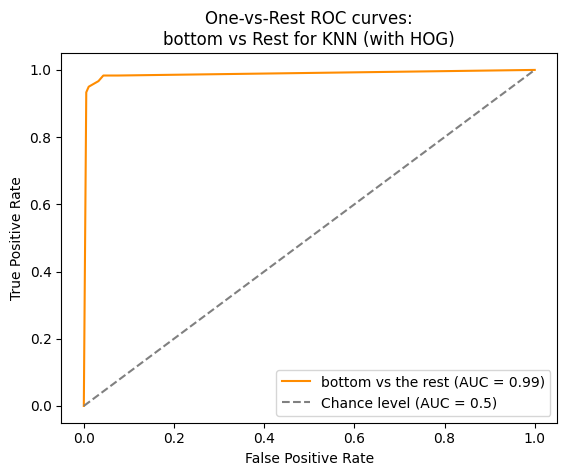

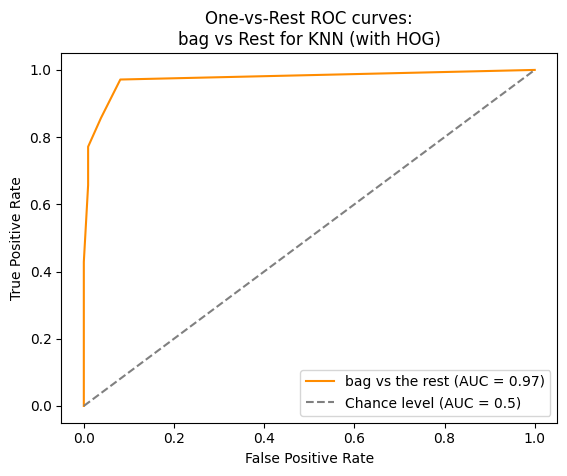

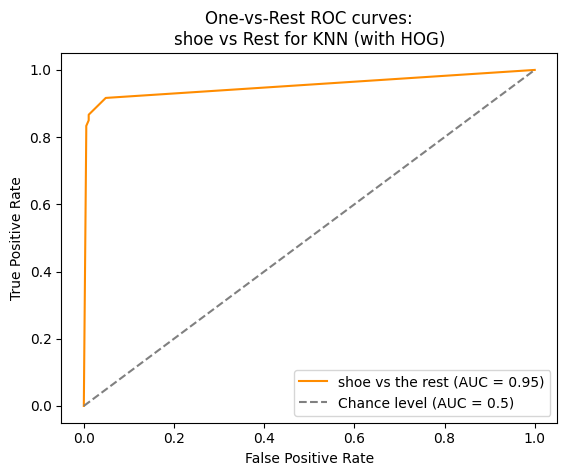

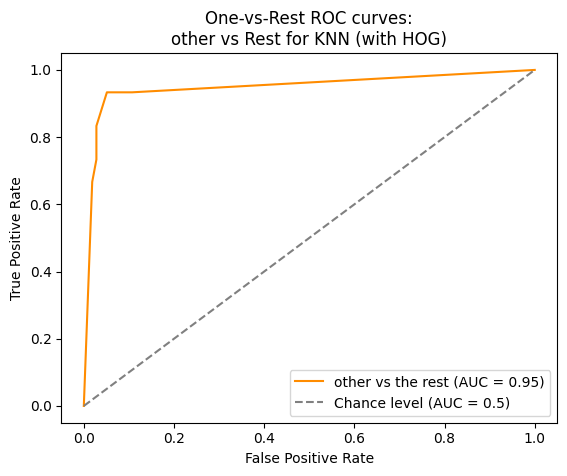

In [73]:
# Plot AUC curves for each category
y_score = knn_hog.predict_proba(X_test_hog)
label_binarizer = LabelBinarizer().fit(y_tr_hog)
y_onehot_test = label_binarizer.transform(y_test_hog)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for KNN (with HOG)",
    )

### Tuning Hyperparameters

In [51]:
# Print default parameters
print("Current params: ", knn_hog.get_params())

Current params:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [52]:
random_grid = { 'n_neighbors' : [1,3,5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

model = KNeighborsClassifier()

# Use random search to find the best hyperparameters
knn_rand_search = RandomizedSearchCV(
    estimator = model,
    param_distributions = random_grid,
    n_iter = 8,
    cv = 5,
)

knn_rand_search.fit(X_tr_hog, y_tr_hog)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=8,
                   param_distributions={'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': [1, 3, 5, 7, 9, 11, 13,
                                                        15],
                                        'weights': ['uniform', 'distance']})

In [53]:
# Shows the most optimal hyperparameter value
knn_rand_search.best_params_

{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'}

In [54]:
# Use the most optimal parameters for the model 
knn_tuned = knn_rand_search.best_estimator_
knn_tuned.fit(X_tr_hog, y_tr_hog)

KNeighborsClassifier(metric='manhattan', n_neighbors=3)

In [55]:
# Testing tuned model on validation set
y_val_pred_hog = knn_tuned.predict(X_val_hog)

# Print results
print("Accuracy for tuned KNN on validation set: "+str(accuracy_score(y_val_hog, y_val_pred_hog)))

Accuracy for tuned KNN on validation set: 0.931059772643931


Results for tuned KNN on test set:
Accuracy: 0.9224489795918367
Precision: 0.917937266320946
Recall: 0.9047619047619048
F1 Score: 0.9104702996175231


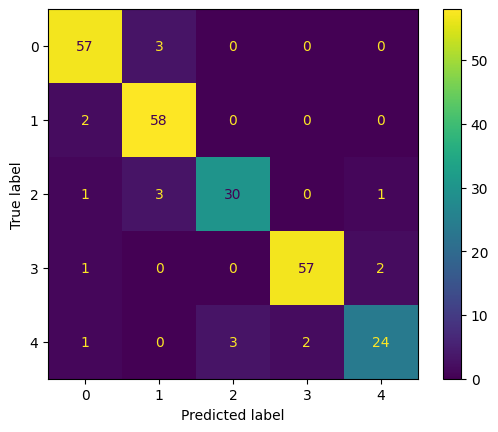

In [74]:
# Testing tuned model on test set
y_pred_hog = knn_tuned.predict(X_test_hog)

# Print results
accuracy_tuned_knn = accuracy_score(y_test_hog, y_pred_hog)
precision_tuned_knn = precision_score(y_test_hog, y_pred_hog, average='macro')
recall_tuned_knn = recall_score(y_test_hog, y_pred_hog, average='macro')
f1_tuned_knn = f1_score(y_test_hog, y_pred_hog, average='macro')
conf_matrix_tuned_knn = confusion_matrix(y_test_hog, y_pred_hog)

print("Results for tuned KNN on test set:")
print(f"Accuracy: {accuracy_tuned_knn}")
print(f"Precision: {precision_tuned_knn}")
print(f"Recall: {recall_tuned_knn}")
print(f"F1 Score: {f1_tuned_knn}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned_knn).plot()

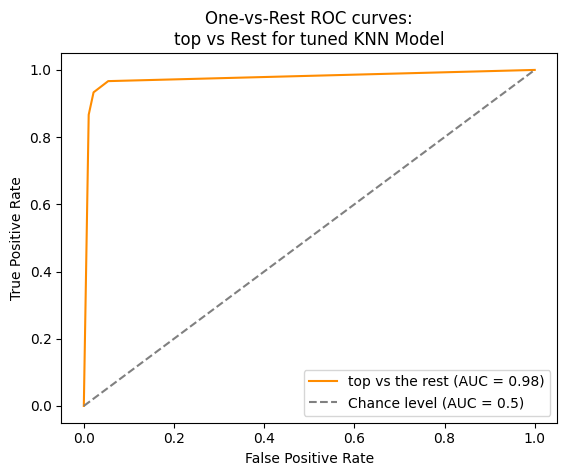

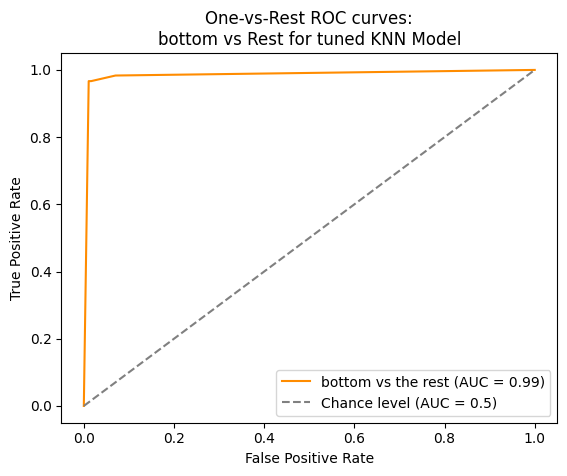

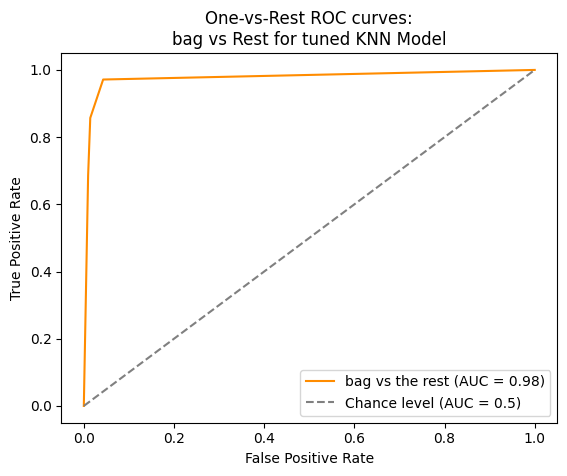

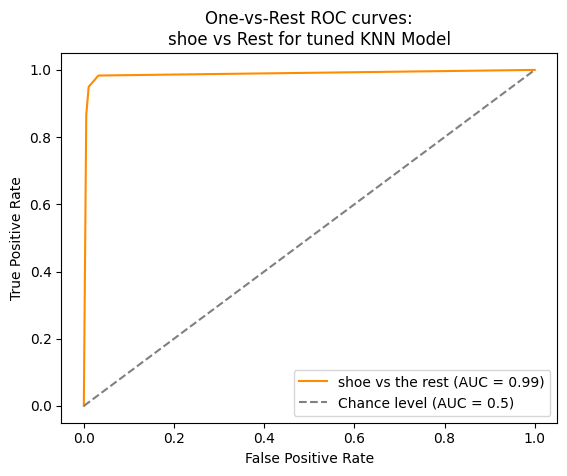

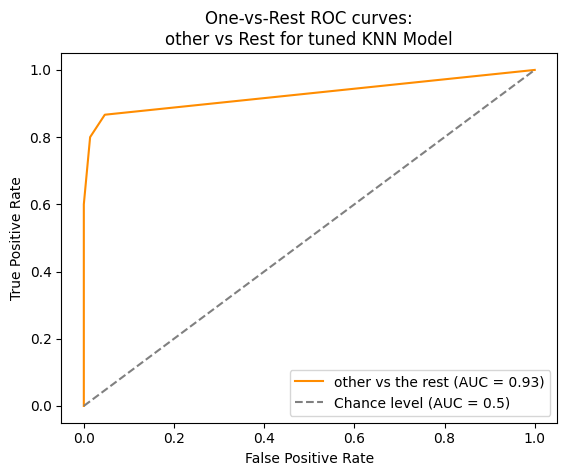

In [57]:
# Plot AUC curves for each category for tuned model
y_score = knn_tuned.predict_proba(X_test_hog)
label_binarizer = LabelBinarizer().fit(y_tr_hog)
y_onehot_test = label_binarizer.transform(y_test_hog)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for tuned KNN Model",
    )

In [75]:
# Metrics comparison before and after tuning 
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'KNN (without HOG)': [accuracy_knn, precision_knn, 
                            recall_knn, f1_knn],
    'KNN (with HOG)': [accuracy_knn_hog, precision_knn_hog, 
                            recall_knn_hog, f1_knn_hog],
    'KNN after tuning (with HOG)': [accuracy_tuned_knn, precision_tuned_knn, 
                      recall_tuned_knn, f1_tuned_knn]
})

metrics

,Metric,KNN (without HOG),KNN (with HOG),KNN after tuning (with HOG)
0,Accuracy,0.673469,0.885714,0.922449
1,Precision,0.653550,0.879224,0.917937
2,Recall,0.619524,0.873333,0.904762
3,F1 Score,0.621904,0.874726,0.910470
